In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/track-master 2.zip"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.utils import shuffle
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2 
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
import random
import tensorflow
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import PReLU
from tensorflow.python.keras import losses
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import keras



In [5]:
def getName(pathname):
  a=pathname.split("\\")[-1]
  return a


In [23]:
columns=['centre','left','right','steering','Throttle','Brake']
data=pd.read_csv("/content/track-master/driving_log.csv",names=columns,index_col=False)
#data.head(10)
#print(data['centre'][0])
data['centre']=data['centre'].apply(getName)
data['left']=data['left'].apply(getName)
data['right']=data['right'].apply(getName)
data.tail(5)
#data.drop(rows=["center_2019_04_02_19_38_12_064.jpg"])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,centre,left,right,steering,Throttle,Brake
4048,center_2018_07_16_17_16_31_474.jpg,left_2018_07_16_17_16_31_474.jpg,right_2018_07_16_17_16_31_474.jpg,0.0,0.0,0.0
4049,center_2018_07_16_17_16_31_544.jpg,left_2018_07_16_17_16_31_544.jpg,right_2018_07_16_17_16_31_544.jpg,0.0,0.0,0.0
4050,center_2018_07_16_17_16_31_617.jpg,left_2018_07_16_17_16_31_617.jpg,right_2018_07_16_17_16_31_617.jpg,0.0,0.0,0.0
4051,center_2018_07_16_17_16_31_685.jpg,left_2018_07_16_17_16_31_685.jpg,right_2018_07_16_17_16_31_685.jpg,0.0,0.0,0.0
4052,center_2018_07_16_17_16_32_161.jpg,left_2018_07_16_17_16_32_161.jpg,right_2018_07_16_17_16_32_161.jpg,0.0,0.0,0.0


In [24]:
def balanceData(data,display=True):
  removeindexList = []
  nBin=31
  samplesPerBin=400
  hist, bins = np.histogram(data['steering'], nBin)
  #Visualizing using histogram
  if display:
    center=(bins[:-1]+bins[1:])*0.5
    print(center)
    plt.bar(center, hist, width=0.06)
    plt.plot((-1,1),(samplesPerBin,samplesPerBin))
    plt.show()
  for j in range(nBin):
    binDataList = []
    for i in range(len(data['steering'])):
      if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
        binDataList.append(i)
    binDataList = shuffle(binDataList)
    #To generate a list of data to be removed.
    binDataList = binDataList[samplesPerBin:]
    removeindexList.extend(binDataList)
 
  print('Removed Images:', len(removeindexList))
  #To remove the data from actual data 
  data.drop(data.index[removeindexList], inplace=True)
  print('Remaining Images:', len(data))
  if display:
    hist, bins = np.histogram(data['steering'], nBin)
    plt.bar(center, hist, width=0.06)
    plt.plot((-1,1),(samplesPerBin,samplesPerBin))
    plt.show()
  return data
  


[-0.96774194 -0.90322581 -0.83870968 -0.77419355 -0.70967742 -0.64516129
 -0.58064516 -0.51612903 -0.4516129  -0.38709677 -0.32258065 -0.25806452
 -0.19354839 -0.12903226 -0.06451613  0.          0.06451613  0.12903226
  0.19354839  0.25806452  0.32258065  0.38709677  0.4516129   0.51612903
  0.58064516  0.64516129  0.70967742  0.77419355  0.83870968  0.90322581
  0.96774194]


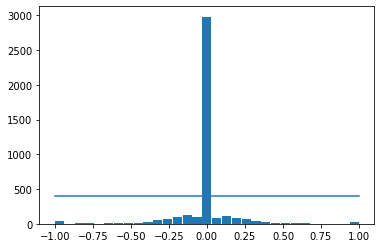

Removed Images: 2580
Remaining Images: 1473


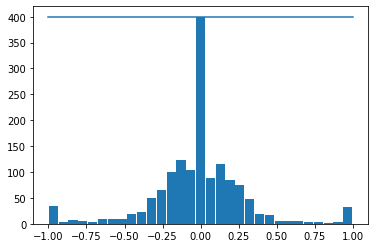

In [25]:
#To balance the data so that it wont result a biased model
data = balanceData(data,display=True)

In [26]:
def loadData(path,data):
  imagesPath=[]
  steerings=[]
  for i in range(len(data)):
    indexedData=data.iloc[i]
    print(indexedData)
    imagesPath.append(os.path.join(path,'IMG',indexedData[0]))
    steerings.append(float(indexedData[3]))
  imagesPath = np.asarray(imagesPath)
  steerings = np.asarray(steerings)
  return imagesPath, steerings
  

  


In [ ]:
imagesPath,steerings=loadData("/content/track-master",data)

In [28]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))


Total Training Images:  1178
Total Validation Images:  295


##**Data Augmentation**





In [29]:
def augImage(imgPath,steering):
  #Importing image data into Numpy arrays¶
  img=mpimg.imread(imgPath)

  #Translate the image
  if np.random.rand() <0.5:
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    img = pan.augment_image(img)
  
  #Zoom
  if np.random.rand() <0.5:
    zoom = iaa.Affine(scale=(1, 1.2))
    img = zoom.augment_image(img)

  #Change the Brightness of image
  if np.random.rand() <0.5:
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)

  #Flip image
  if np.random.rand() <0.5:
    img = cv2.flip(img, 1)
    steering = -steering
  return img,steering

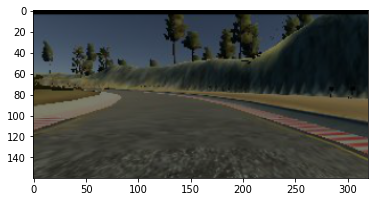

In [43]:
#Testing using one image
a,_=augImage('/content/track-master/IMG/center_2018_07_16_17_11_43_382.jpg',0)
plt.imshow(a)

## **Preprocessing**

In [37]:
def preProcess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

## **Batch Generator**

In [38]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
  while True:
    imgBatch = []
    steeringBatch =[]
    for i in range(batchSize):
      index = random.randint(0, len(imagesPath) - 1)
      if trainFlag:
        img, steering = augImage(imagesPath[index], steeringList[index])
      else:
        img = mpimg.imread(imagesPath[index])
        steering = steeringList[index]
      img = preProcess(img)
      imgBatch.append(img)
      steeringBatch.append(steering)
    yield (np.asarray(imgBatch),np.asarray(steeringBatch))
    

In [39]:
def createModel():
  model = Sequential()
 
  model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
 
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  opt=Adam(learning_rate=0.0001)
  #model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  model.compile(optimizer=opt,loss='mse')
  return model

In [40]:
model = createModel()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_12 (Dense)            (None, 100)              

## **Training process starts here**

In [41]:
model.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=15,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200,
                                  verbose = 1, 
                                  shuffle = 1)

Epoch 1/15
300/300 [==============================] - 388s 1s/step - loss: 0.0954 - val_loss: 0.0618
Epoch 2/15
300/300 [==============================] - 384s 1s/step - loss: 0.0666 - val_loss: 0.0532
Epoch 3/15
300/300 [==============================] - 365s 1s/step - loss: 0.0624 - val_loss: 0.0534
Epoch 4/15
300/300 [==============================] - 362s 1s/step - loss: 0.0586 - val_loss: 0.0517
Epoch 5/15
300/300 [==============================] - 361s 1s/step - loss: 0.0540 - val_loss: 0.0463
Epoch 6/15
300/300 [==============================] - 363s 1s/step - loss: 0.0490 - val_loss: 0.0450
Epoch 7/15
300/300 [==============================] - 359s 1s/step - loss: 0.0470 - val_loss: 0.0362
Epoch 8/15
300/300 [==============================] - 362s 1s/step - loss: 0.0427 - val_loss: 0.0344
Epoch 9/15
300/300 [==============================] - 362s 1s/step - loss: 0.0420 - val_loss: 0.0347
Epoch 10/15
300/300 [==============================] - 360s 1s/step - loss: 0.0382 - val_lo

In [42]:
model.save('/content/selfdrivingmodel.h5') #saving model


In [ ]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from tensorflow.keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2
 
#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'
 
maxSpeed = 10
 
 
def preProcess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img
 
 
@sio.on('telemetry')
def telemetry(sid, data):
  speed = float(data['speed'])
  image = Image.open(BytesIO(base64.b64decode(data['image'])))
  image = np.asarray(image)
  image = preProcess(image)
  image = np.array([image])
  steering = float(model.predict(image))
  throttle = 1.0 - speed / maxSpeed
  print(f'{steering}, {throttle}, {speed}')
  sendControl(steering, throttle)
 
 
@sio.on('connect')
def connect(sid, environ):
  print('Connected')
  sendControl(0, 0)
 
 
def sendControl(steering, throttle):
  sio.emit('steer', data={
 'steering_angle': steering.__str__(),
  'throttle': throttle.__str__()
    })
 
 
if __name__ == '__main__':
  model = load_model('selfdrivingmodel.h5')
  app = socketio.Middleware(sio, app)
  ### LISTEN TO PORT 4567
  eventlet.wsgi.server(eventlet.listen(('', 4567)), app)